In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import UpSampling2D


In [2]:
vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

model = Sequential()
# model.add(UpSampling2D(input_shape=(32, 32, 3)))
for layer in vgg16_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()

2023-05-11 16:54:43.933953: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 16:54:45.120869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2631 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e3:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

In [3]:
(X_train, y_train), (X_test, y_test) = k.datasets.cifar10.load_data()

# Convert class vectors to binary class matrices using one hot encoding
y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

# Data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

X_val = X_train[40000:]
y_val = y_train_ohe[40000:]
X_train = X_train[:40000]
y_train_ohe = y_train_ohe[:40000]

In [4]:
# initiate SGD optimizer
sgd = optimizers.SGD(lr=0.001, momentum=0.9)

# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')


# initialize the number of epochs and batch size
EPOCHS = 40
BS = 128
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest")
 
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

# train the model
history = model.fit_generator(
    aug.flow(X_train,y_train_ohe, batch_size=BS),
    validation_data=(X_val,y_val),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS)

# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))


Training started at %s Thu May 11 16:54:49 2023
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/tmp/ipykernel_465/934648463.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-05-11 16:54:52.796323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-05-11 16:54:54.862871: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-11 16:54:54.863992: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-11 16:54:54.864029: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-11 16:54:54.865262: I tensorflow

312/312 [==============================] - 47s 121ms/step - loss: 1.8020 - accuracy: 0.3434 - val_loss: 1.1230 - val_accuracy: 0.6077
Epoch 2/40
312/312 [==============================] - 27s 86ms/step - loss: 1.2061 - accuracy: 0.5790 - val_loss: 0.8686 - val_accuracy: 0.6992
Epoch 3/40
312/312 [==============================] - 25s 81ms/step - loss: 1.0161 - accuracy: 0.6558 - val_loss: 0.7649 - val_accuracy: 0.7379
Epoch 4/40
312/312 [==============================] - 26s 82ms/step - loss: 0.9149 - accuracy: 0.6914 - val_loss: 0.7425 - val_accuracy: 0.7493
Epoch 5/40
312/312 [==============================] - 25s 80ms/step - loss: 0.8375 - accuracy: 0.7186 - val_loss: 0.6617 - val_accuracy: 0.7802
Epoch 6/40
312/312 [==============================] - 24s 77ms/step - loss: 0.7851 - accuracy: 0.7350 - val_loss: 0.6791 - val_accuracy: 0.7684
Epoch 7/40
312/312 [==============================] - 24s 76ms/step - loss: 0.7433 - accuracy: 0.7509 - val_loss: 0.5852 - val_accuracy: 0.7950
Ep

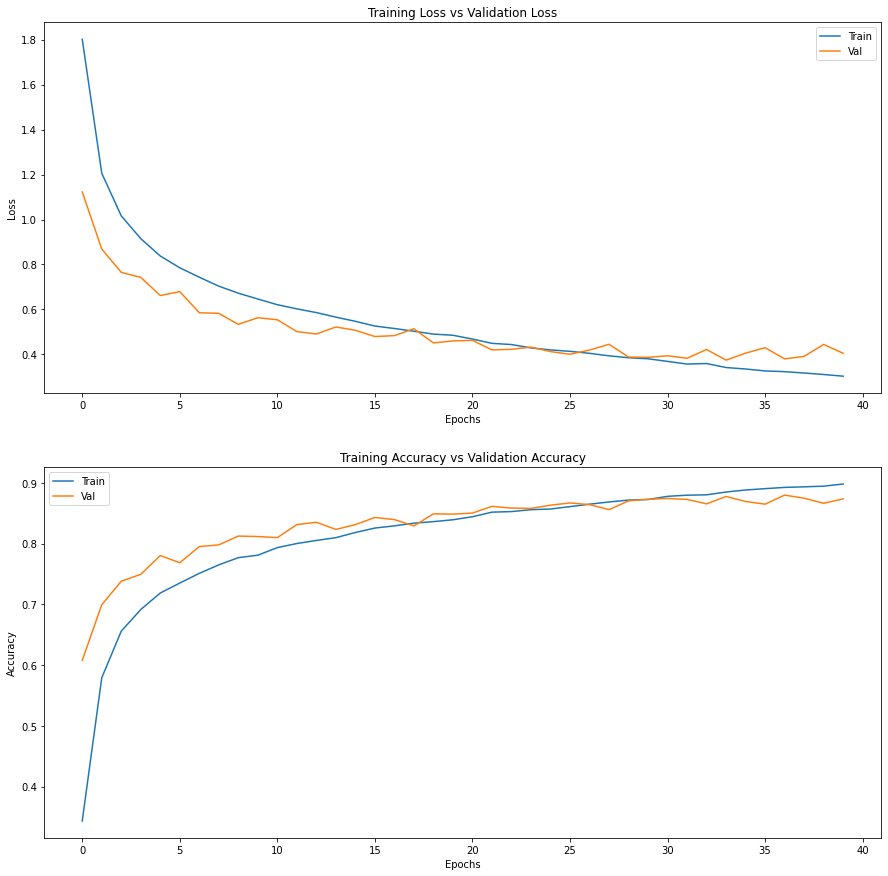

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [6]:
model.evaluate(X_test, y_test_ohe)

313/313 [==============================] - 8s 25ms/step - loss: 0.4433 - accuracy: 0.8645


[0.44330623745918274, 0.8644999861717224]